In [1]:
import os
import scanpy as sc
from help_func import *
pd.set_option('display.max_columns', 500)
import re

### import ATAC data

In [2]:
ATAC_data = sc.read_h5ad('./10X_pbmc_ATAC_celltype_filtered.h5ad')
ATAC_data

AnnData object with n_obs × n_vars = 8794 × 105472
    obs: 'celltype', 'n_genes'
    var: 'peak', 'gene', 'distance', 'peak_type', 'n_cells', 'chr', 'from', 'to'

In [3]:
ATAC_peaks = ATAC_data.var
ATAC_promoters = ATAC_peaks[ATAC_peaks['peak_type'] == 'promoter']
ATAC_promoters

,peak,gene,distance,peak_type,n_cells,chr,from,to
chr1:777634-779926,chr1:777634-779926,LINC01409,0,promoter,3447,chr1,777634,779926
chr1:816881-817647,chr1:816881-817647,FAM87B,0,promoter,487,chr1,816881,817647
chr1:869449-870383,chr1:869449-870383,FAM41C,0,promoter,1116,chr1,869449,870383
chr1:903617-907386,chr1:903617-907386,AL645608.6,0,promoter,2053,chr1,903617,907386
chr1:920493-926443,chr1:920493-926443,SAMD11,0,promoter,1551,chr1,920493,926443
...,...,...,...,...,...,...,...,...
chrX:155262922-155264853,chrX:155262922-155264853,RAB39B,0,promoter,1055,chrX,155262922,155264853
chrX:155611306-155613309,chrX:155611306-155613309,TMLHE,0,promoter,817,chrX,155611306,155613309
chrX:155767383-155767733,chrX:155767383-155767733,SPRY3,-79,promoter,69,chrX,155767383,155767733
chrX:155880572-155882091,chrX:155880572-155882091,VAMP7,0,promoter,1393,chrX,155880572,155882091


### import Chip-seq data

In [4]:
root_file = 'D:/Users/jtyu/10X/Chip-seq/targets-GRCh38/Bed file/'
Chipseq_files_name = os.listdir(root_file)

In [5]:
TF_list = [Chipseq_files_name[i][0:-4] for i in range(len(Chipseq_files_name))]

### import PCHIC data

In [6]:
pcHiC_data = pd.read_csv('../10X/pcHiC/ActivePromoterEnhancerLinks.tsv', sep='\t')

In [7]:
pcHiC_promoters = pcHiC_data.drop_duplicates(subset=['baitID'], keep='first', inplace=False, ignore_index=False)
pcHiC_promoters.index = pcHiC_promoters['baitID']
pcHiC_promoters

,baitChr,baitSt,baitEnd,baitID,oeChr,oeSt,oeEnd,oeID,cellType(s),sample(s)
baitID,,,,,,,,,,
254,chr1,1206873,1212438,254,chr1,943676,957199,228,nCD8,C0066PH1
257,chr1,1239425,1278099,257,chr1,1034268,1040208,235,"nCD4,nCD8,Mac0,Mac1,Mac2,MK,Mon","S007DDH2,S007G7H4,C0066PH1,S00C2FH1,S00390H1,S..."
263,chr1,1309968,1313315,263,chr1,1083958,1091234,243,nCD8,"C0066PH1,S00C2FH1"
291,chr1,1505406,1516638,291,chr1,1545982,1552729,298,"Mac1,Mac2,Neu","S0022IH2,S00BS4H1,C0011IH2,C001UYH1,C12012H1"
298,chr1,1545982,1552729,298,chr1,1647156,1648710,310,Ery,"S002R5H1,S002S3H1"
...,...,...,...,...,...,...,...,...,...,...
832872,chrY,15015252,15016313,832872,chrY,14772017,14779928,832781,nCD4,S007G7H4
833067,chrY,15590405,15597670,833067,chrY,15019776,15023168,832877,"nCD4,nCD8","S007G7H4,S00C2FH1"
835021,chrY,21716816,21732795,835021,chrY,21594789,21596096,834975,"nCD4,nCD8,Mon,Neu","S007G7H4,S00C2FH1,C000S5H2,C000S5H1"


### align promoters of scATAC and pcHIC

In [8]:
ATAC_promoters_append_PCHIC_promoter = pd.DataFrame()

for temp_atac_pro in ATAC_promoters.index:
    # search in same chromosome
    temp_pchic_pro_df = pcHiC_promoters[pcHiC_promoters['baitChr'] == ATAC_promoters['chr'].loc[temp_atac_pro]]

    res_list = []
    for temp_pchic_pro in temp_pchic_pro_df.index:
        res = is_pchic_validated(int(ATAC_promoters['from'].loc[temp_atac_pro]),
                                 int(ATAC_promoters['to'].loc[temp_atac_pro]),
                                 int(temp_pchic_pro_df['baitSt'].loc[temp_pchic_pro]),
                                 int(temp_pchic_pro_df['baitEnd'].loc[temp_pchic_pro]),
                                 thre=0.5)
        res_list.append(res)
        # have corresponding promoter
        if res == 1:
            ATAC_promoters_append_PCHIC_promoter = ATAC_promoters_append_PCHIC_promoter.append(
                temp_pchic_pro_df[['baitChr', 'baitSt', 'baitEnd', 'baitID']].loc[temp_pchic_pro])
            break

    # haven't corresponding promoter
    if sum(res_list) == 0:
        ATAC_promoters_append_PCHIC_promoter = ATAC_promoters_append_PCHIC_promoter.append(
            pd.DataFrame(np.zeros((1, 4)), columns=['baitChr', 'baitSt', 'baitEnd', 'baitID']))

ATAC_promoters_append_PCHIC_promoter.index = ATAC_promoters.index
ATAC_promoters = ATAC_promoters.join(ATAC_promoters_append_PCHIC_promoter)

In [30]:
ATAC_promoters[ATAC_promoters['baitID'] != 0].shape

(767, 12)

### intersection of PCHIC & CHIPseq & ATAC

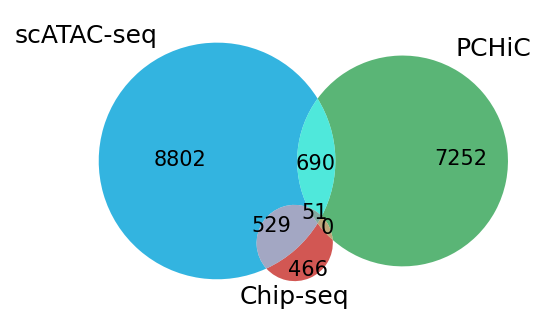

In [27]:
from matplotlib_venn import venn3

my_dpi=150
plt.figure(figsize=(600/my_dpi, 600/my_dpi), dpi=my_dpi)#控制图尺寸的同时，使图高分辨率（高清）显示
g=venn3(subsets = [set(ATAC_promoters['gene']),
                   set(ATAC_promoters[ATAC_promoters['baitID'] != 0]['gene']).union(
                   set(np.array(range(pcHiC_promoters.shape[0]-
                                      ATAC_promoters[ATAC_promoters['baitID'] != 0].shape[0])).astype(str))),
                   set(TF_list)], 
        set_labels = ('scATAC-seq', 'PCHiC','Chip-seq'), 
        set_colors=("#01a2d9", "#31A354", "#c72e29"),
        alpha=0.8,
        normalize_to=1.0
       )
plt.savefig('./veen.svg')

In [9]:
ATAC_promoters = ATAC_promoters[ATAC_promoters['baitID'] != 0]

In [11]:
keep_promoter = list((set(ATAC_promoters['gene'])).intersection(TF_list))

In [20]:
ATAC_promoters = ATAC_promoters[ATAC_promoters['gene'].isin(keep_promoter)]

### import peaks embedding of SCARP and compute cos similarity

In [15]:
SCARP_peaks_embedding = pd.read_csv('./10X_pbmc_ATAC_celltype_filtered_SCARP_Peaks_feature.csv', index_col=0)
print(SCARP_peaks_embedding.shape)
SCARP_peaks_embedding.head(5)

(105472, 20)


,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20
chr1:10109-10357,-0.896440,-0.188033,-0.050336,0.218941,0.066854,0.132769,-0.116998,-0.121226,0.002033,-0.122799,-0.016226,-0.060801,0.102160,-0.035574,-0.023660,0.017494,-0.005220,-0.134633,-0.101605,-0.000192
chr1:180730-181630,-0.944147,-0.129957,-0.064224,0.151908,0.016262,0.040529,-0.076994,-0.052981,-0.038752,-0.079526,-0.039363,-0.076003,-0.060896,-0.042133,0.001630,-0.074327,0.123856,-0.060179,-0.027948,-0.089153
chr1:191491-191736,-0.880155,0.236058,-0.119798,0.080640,-0.180620,0.014582,-0.049483,-0.165396,-0.028720,-0.157776,0.082207,0.029339,-0.179950,-0.101794,0.010326,-0.044853,-0.023522,0.011399,0.042356,-0.073703
chr1:267816-268196,-0.936199,0.271511,-0.107792,-0.070832,-0.090792,0.043668,-0.046689,-0.058964,0.006678,-0.057327,-0.014427,0.014118,0.007528,-0.025255,-0.034405,0.074821,-0.022096,-0.062441,0.042054,-0.000057
chr1:586028-586373,-0.934047,0.054579,-0.077207,-0.048448,-0.150969,0.013921,-0.044431,-0.078204,-0.004981,0.038910,-0.184712,0.009839,0.053739,0.079083,0.039147,0.021340,-0.073396,0.137437,-0.084745,0.082779


In [23]:
L2_row = np.linalg.norm(SCARP_peaks_embedding.loc[ATAC_promoters.index], axis=1).reshape(-1, 1)
L2_col = np.linalg.norm(SCARP_peaks_embedding.loc[ATAC_peaks.index], axis=1).reshape(-1, 1)

SCARP_promoter_peak_cor = SCARP_peaks_embedding.loc[ATAC_promoters.index].dot(
    SCARP_peaks_embedding.loc[ATAC_peaks.index].T)/L2_row.dot(L2_col.T)
SCARP_promoter_peak_cor = pd.DataFrame(SCARP_promoter_peak_cor,
                                       index=ATAC_promoters.index,
                                       columns=ATAC_peaks.index)
SCARP_promoter_peak_cor.shape

(53, 105472)

###  compute distance

In [30]:
promoter_peak_dist = np.zeros(SCARP_promoter_peak_cor.shape)
for i in range(SCARP_promoter_peak_cor.shape[0]):
    peak_i = re.split(r'[:,-]', SCARP_promoter_peak_cor.index[i])

    for j in range(SCARP_promoter_peak_cor.shape[0]):
        peak_j = re.split(r'[:,-]', SCARP_promoter_peak_cor.columns[j])

        if peak_i[0] == peak_j[0]:  
            promoter_peak_dist[i, j] = max(int(peak_j[1]) - int(peak_i[2]),
                                           int(peak_i[1]) - int(peak_j[2]))
promoter_peak_dist = pd.DataFrame(promoter_peak_dist,                          
                                  index=SCARP_promoter_peak_cor.index,
                                  columns=SCARP_promoter_peak_cor.columns)
print(promoter_peak_dist.shape)

(53, 105472)


In [33]:
SCARP_promoter_peak_cor_closer = SCARP_promoter_peak_cor[promoter_peak_dist<250000]

In [35]:
SCARP_promoter_peak_cor_closer = SCARP_promoter_peak_cor_closer.fillna(0)

In [39]:
SCARP_promoter_peak_cor_closer = SCARP_promoter_peak_cor_closer[SCARP_promoter_peak_cor_closer>0.8]

In [87]:
x = enumerate([pcHiC_data[pcHiC_data['baitID']==ATAC_promoters['baitID'][i]].shape[0] for i in range(ATAC_promoters.shape[0])])
set(x)

{(0, 1),
 (1, 1),
 (2, 4),
 (3, 1),
 (4, 8),
 (5, 2),
 (6, 2),
 (7, 11),
 (8, 2),
 (9, 1),
 (10, 5),
 (11, 3),
 (12, 8),
 (13, 1),
 (14, 2),
 (15, 3),
 (16, 3),
 (17, 2),
 (18, 3),
 (19, 5),
 (20, 5),
 (21, 7),
 (22, 11),
 (23, 1),
 (24, 3),
 (25, 3),
 (26, 12),
 (27, 3),
 (28, 1),
 (29, 3),
 (30, 2),
 (31, 10),
 (32, 1),
 (33, 4),
 (34, 1),
 (35, 1),
 (36, 1),
 (37, 10),
 (38, 1),
 (39, 2),
 (40, 22),
 (41, 4),
 (42, 10),
 (43, 6),
 (44, 30),
 (45, 1),
 (46, 1),
 (47, 6),
 (48, 5),
 (49, 1),
 (50, 4),
 (51, 2),
 (52, 12)}

In [88]:
ATAC_promoters.iloc[44,:]

peak         chr6:20399555-20405156
gene                           E2F3
distance                          0
peak_type                  promoter
n_cells                        6007
chr                            chr6
from                       20399555
to                         20405156
baitChr                        chr6
baitSt                   20400927.0
baitEnd                  20403179.0
baitID                     616519.0
Name: chr6:20399555-20405156, dtype: object